In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
# from keras.losses import SparseCategoricalCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from keras import callbacks,layers

import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Before the ML modeling, a preprocessing must be done in the dataset. We will use Normalization, Outlier Filtering, Correlation Filtering and Equalization.

In [3]:
df = pd.read_csv('/kaggle/input/ids-intrusion-csv/02-14-2018.csv')

## Preliminary Data Cleaning

Check existence and drop -inf and +inf values

In [4]:
# replace +ve and -ve infinity with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop all NaN values
df.dropna(inplace=True)

In [5]:
count = df['Label'].value_counts()  # Perform value count on the 'A' column
print(f"Value counts for dataframe:\n{count}\n")

Value counts for dataframe:
Benign            663808
FTP-BruteForce    193354
SSH-Bruteforce    187589
Name: Label, dtype: int64



Convert Timestamp values to pandas date and time datetime64 format

In [6]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

Convert datetime64 format to epoch format (epoch is Unix epoch time format, wich represents the number of seconds elapsed since January 1, 1970, at 00:00:00 UTC)

In [7]:
df['Timestamp'] = (df['Timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

Change all misclassified datatypes to float and substitute errors by NaN

In [8]:
for col in df.columns:
    #Check if the datatype of the column is object
    if df[col].dtype == 'object' and col != 'Label':
        # Change all values to numeric, and to NaN if it is a strig
        df[col] = pd.to_numeric(df[col], errors='coerce')

Count and drop NaN values

In [9]:
print(df.isna().sum())
df.dropna(inplace=True)

Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Label            0
Length: 80, dtype: int64


## Outliers Filtering

In [10]:
from scipy import stats

# Define a function to filter outliers using Z-score
def filter_outliers_zscore(data, threshold):
    z_scores = np.abs(stats.zscore(data))
    outlier_mask = (z_scores > threshold).any(axis=1)
    return data[~outlier_mask], data[outlier_mask]

# Define a threshold value
threshold = 7


# # The filtering was removing all DDoS-LOIC-UDP, so we will not execute it on them

# if key == '02-21-2018':
#     df_temp = df[df['Label'] == 'DDOS attack-LOIC-UDP']
#     df = df[df['Label'] != 'DDOS attack-LOIC-UDP']




# Loop through the columns of the dataframe and filter outliers in each column
filtered_cols = []
removed_outliers = []
for col in df.columns:
    if col != 'Label':
        filtered_col, outliers = filter_outliers_zscore(df[[col]], threshold)

        filtered_cols.append(filtered_col)
        removed_outliers.append(outliers)

# Combine the filtered columns back into a dataframe
df_filtered = pd.concat(filtered_cols, axis=1)

# Combine the removed outliers back into a dataframe
df_outliers = pd.concat(removed_outliers, axis=1)






# Dataframe filtering comparison

print(f'\nDataframe Shape: {df.shape}')

# Print the number of outliers removed for each column

print('Outlier removal summary:')
n_outliers = df_outliers.shape[0]
print(f'{n_outliers} outliers rows to be removed')

# Print the original dataframe and the filtered dataframe side by side
print('\nOriginal dataframe:')
display(df.head())

# Assign filtered dataframe columns to original one
columns = [col for col in df.columns if col != 'Label']
df.loc[:,columns] = df_filtered.loc[:,columns]


# # Recombine rows from 'DDOS attack-LOIC-UDP'
# if key == '02-21-2018':
#     df = pd.concat([df,df_temp])


print('\nFiltered dataframe:')
display(df.head())

# Print the removed outliers dataframe
print('\nRemoved outliers:')
display(df_outliers.head())

# Count how many rows of each attack were removed from original dataframe
values_orig = df.loc[df.index.isin(df_outliers.index), 'Label']
print(f'\n{values_orig.value_counts()}')

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)





Dataframe Shape: (1044751, 80)
Outlier removal summary:
33654 outliers rows to be removed

Original dataframe:


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,1518597061,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,1518597230,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,1518597399,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,1518597613,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,1518597623,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign



Filtered dataframe:


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,1.518597e+09,112641719.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,56320859.5,139.300036,56320958.0,56320761.0,Benign
1,0,0,1.518597e+09,112641466.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,56320733.0,114.551299,56320814.0,56320652.0,Benign
2,0,0,1.518597e+09,112638623.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,56319311.5,301.934596,56319525.0,56319098.0,Benign
3,22,6,1.518598e+09,6453966.0,15.0,10.0,1239.0,2273.0,744.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,22,6,1.518598e+09,8804066.0,14.0,11.0,1143.0,2209.0,744.0,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign



Removed outliers:


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
410956,NaN,NaN,356477.0,-1.187300e+10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410957,NaN,NaN,631953.0,-6.814020e+11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
410958,NaN,NaN,976676.0,-9.190110e+11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.841125e+11,1.931524e+11,7.548470e+11,1.260300e+10
410959,NaN,NaN,983710.0,-2.738500e+11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.394503e+11,2.432682e+11,9.797810e+11,7.758000e+09
412184,NaN,NaN,985452.0,-5.298010e+11,505.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.337556e+11,2.377517e+11,9.484310e+11,4.908000e+09



Benign    33654
Name: Label, dtype: int64


In [11]:
display(df.describe())

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,...,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06,1.011097e+06
mean,4.617869e+03,8.169613e+00,1.518595e+09,6.366756e+06,5.005059e+00,4.447752e+00,3.792241e+02,8.347496e+02,1.692143e+02,8.315534e+00,...,2.648352e+00,2.342916e+01,1.470823e+04,7.105414e+03,3.260628e+04,1.184884e+04,1.143227e+06,1.719559e+04,1.153016e+06,1.111306e+06
std,1.407674e+04,4.505407e+00,1.443707e+04,2.224621e+07,6.989601e+00,7.286993e+00,7.507051e+02,3.461690e+03,2.685747e+02,1.700098e+01,...,5.011792e+00,1.121421e+01,1.553650e+05,6.870820e+04,2.602018e+05,1.506151e+05,6.867112e+06,3.440432e+05,6.894340e+06,6.829427e+06
min,0.000000e+00,0.000000e+00,1.518570e+09,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.200000e+01,6.000000e+00,1.518578e+09,7.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.300000e+01,6.000000e+00,1.518602e+09,9.510000e+02,2.000000e+00,1.000000e+00,3.500000e+01,5.200000e+01,3.300000e+01,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,6.000000e+00,1.518607e+09,3.876120e+05,6.000000e+00,5.000000e+00,3.640000e+02,5.540000e+02,1.610000e+02,0.000000e+00,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553300e+04,1.700000e+01,1.518613e+09,1.200000e+08,2.650000e+02,4.600000e+02,2.769000e+04,5.432450e+05,1.460000e+03,1.370000e+02,...,4.000000e+01,4.800000e+01,4.067542e+06,1.554120e+06,5.243341e+06,3.959858e+06,1.199907e+08,7.021683e+07,1.199907e+08,1.199907e+08


## Normalization

In [12]:
from sklearn.preprocessing import MinMaxScaler
columns = [col for col in df.columns if col != 'Label']
min_max_scaler = MinMaxScaler().fit(df[columns])
df[columns] = min_max_scaler.transform(df[columns])
display(df.head())

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0.000000,0.000000,0.626427,0.938681,0.007576,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.469377,0.000002,0.469378,0.469376,Benign
1,0.000000,0.000000,0.630339,0.938679,0.007576,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.469376,0.000002,0.469376,0.469375,Benign
2,0.000000,0.000000,0.634251,0.938655,0.007576,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.469364,0.000004,0.469366,0.469362,Benign
3,0.000336,0.352941,0.639205,0.053783,0.053030,0.021739,0.044745,0.004184,0.509589,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,Benign
4,0.000336,0.352941,0.639436,0.073367,0.049242,0.023913,0.041278,0.004066,0.509589,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,Benign


## Feature Correlation Filtering

In [13]:
columns = [col for col in df.columns if col != 'Label']

corr_matrix = df[columns].corr().abs()

threshold = 0.99
# Find features with high correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Print features to drop
print(f"The following {len(to_drop)} features will be dropped due to high correlation: {to_drop}")

df = df.drop(to_drop, axis = 1)

# replace +ve and -ve infinity with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop all NaN values
df.dropna(inplace=True)


The following 16 features will be dropped due to high correlation: ['Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Min', 'Pkt Len Min', 'Pkt Len Max', 'SYN Flag Cnt', 'ECE Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Idle Max', 'Idle Min']


## Binarize the data for modeling

In [14]:
df["Label"] = df.Label.map(lambda a:"normal" if a == 'Benign' else "abnormal")

## Equalization

In [15]:
df = df.sample(frac=1) #Randomize rows's sequence

df2 = df[df["Label"] == "abnormal"]

df0 = df[df["Label"] == "normal"][:df2.shape[0]]

df = pd.concat([ df0,df2], axis =0)


## Final Preprocessed Data Visualization

In [16]:
print(f"{df['Label'].value_counts()}\n")
display(df.describe())
display(df.head())
display(df.info())

normal      380943
abnormal    380943
Name: Label, dtype: int64



,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std
count,761886.000000,761886.000000,761886.000000,7.618860e+05,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,...,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000,761886.000000
mean,0.056496,0.455563,0.562558,4.251198e-02,0.016112,0.010328,0.014375,0.001466,0.114369,0.048823,...,0.192138,0.077633,0.072550,0.540122,0.002894,0.003678,0.004983,0.002391,0.007606,0.000193
std,0.194220,0.242906,0.340339,1.668585e-01,0.028402,0.016534,0.027588,0.005705,0.184922,0.113947,...,0.203880,0.254271,0.136435,0.236988,0.034203,0.039721,0.044511,0.034039,0.051275,0.004410
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000320,0.352941,0.169147,4.166667e-08,0.000000,0.002174,0.000000,0.000000,0.000000,0.000000,...,0.003693,0.000000,0.000000,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000336,0.352941,0.731406,3.158334e-06,0.000000,0.002174,0.000000,0.000000,0.000000,0.000000,...,0.125015,0.000015,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.001221,0.352941,0.859603,3.108846e-03,0.018939,0.010870,0.013146,0.000941,0.110274,0.000000,...,0.410217,0.003525,0.075000,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000e+00,1.000000,0.823913,0.960130,0.821256,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.996383,0.998352,1.000000,1.000000


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Label
466902,0.006760,0.352941,0.883817,0.002450,0.030303,0.015217,0.059010,0.008828,0.553425,0.000000,...,0.015594,0.100,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,normal
629969,0.006760,0.352941,0.925369,0.923539,0.060606,0.043478,0.020910,0.001668,0.354110,0.000000,...,0.020020,0.325,0.416667,0.018092,0.080194,0.077484,0.005269,0.083335,0.000329,normal
477636,0.000809,1.000000,0.088058,0.000211,0.003788,0.004348,0.003106,0.000379,0.029452,0.313869,...,0.000000,0.025,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,normal
511872,0.000809,1.000000,0.990532,0.001568,0.003788,0.004348,0.002384,0.000394,0.022603,0.240876,...,0.000000,0.025,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,normal
839069,0.000809,1.000000,0.287298,0.000003,0.000000,0.002174,0.002600,0.000191,0.049315,0.525547,...,0.000000,0.000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,normal


<class 'pandas.core.frame.DataFrame'>
Int64Index: 761886 entries, 466902 to 34171
Data columns (total 64 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           761886 non-null  float64
 1   Protocol           761886 non-null  float64
 2   Timestamp          761886 non-null  float64
 3   Flow Duration      761886 non-null  float64
 4   Tot Fwd Pkts       761886 non-null  float64
 5   Tot Bwd Pkts       761886 non-null  float64
 6   TotLen Fwd Pkts    761886 non-null  float64
 7   TotLen Bwd Pkts    761886 non-null  float64
 8   Fwd Pkt Len Max    761886 non-null  float64
 9   Fwd Pkt Len Min    761886 non-null  float64
 10  Fwd Pkt Len Mean   761886 non-null  float64
 11  Fwd Pkt Len Std    761886 non-null  float64
 12  Bwd Pkt Len Max    761886 non-null  float64
 13  Bwd Pkt Len Min    761886 non-null  float64
 14  Bwd Pkt Len Mean   761886 non-null  float64
 15  Bwd Pkt Len Std    761886 non-null  float64
 16

None

The dataframe is using more memory than the original one because there are more decimal precision and less null values. So, even if as we droped a lot of values, the preprocessed dataframe uses more memory. To contour this, we will round the data. Keep in mind that this will cause some loss of precision.

In [17]:
# Round the numeric columns to the specified decimal places
df_rounded = df.round(5)

In [18]:
display(df_rounded.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761886 entries, 466902 to 34171
Data columns (total 64 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           761886 non-null  float64
 1   Protocol           761886 non-null  float64
 2   Timestamp          761886 non-null  float64
 3   Flow Duration      761886 non-null  float64
 4   Tot Fwd Pkts       761886 non-null  float64
 5   Tot Bwd Pkts       761886 non-null  float64
 6   TotLen Fwd Pkts    761886 non-null  float64
 7   TotLen Bwd Pkts    761886 non-null  float64
 8   Fwd Pkt Len Max    761886 non-null  float64
 9   Fwd Pkt Len Min    761886 non-null  float64
 10  Fwd Pkt Len Mean   761886 non-null  float64
 11  Fwd Pkt Len Std    761886 non-null  float64
 12  Bwd Pkt Len Max    761886 non-null  float64
 13  Bwd Pkt Len Min    761886 non-null  float64
 14  Bwd Pkt Len Mean   761886 non-null  float64
 15  Bwd Pkt Len Std    761886 non-null  float64
 16

None

It still displays the same memory usage, but when we save it to a .csv file it will be significantly smaller (in this run it went from 400+ MB to 210 MB)

## Save preprocessed dataset

In [19]:
df_rounded.to_csv('/kaggle/working/preproc_data.csv', index = False)

## Building functions for modeling

In [20]:
def splits_assemble(path, test_size=0.3):
    # Import dataset
    df_dataset = pd.read_csv(path)

    # Encode Labels for numeric classification
    label_encoder = LabelEncoder()
    df_dataset['Label'] = label_encoder.fit_transform(df_dataset['Label'])

    # Set a random state for sampling
    RANDOM_STATE_SEED = np.random.randint(123)
    print(f'Random Seed:{RANDOM_STATE_SEED}')
    
    # Split dataset in train and test
    train, test = train_test_split(df_dataset, test_size=test_size, random_state=RANDOM_STATE_SEED)
    
    # Count how many instances there are in each label
    print(df_dataset["Label"].value_counts())

    # Separate in X and y for better classification
    y_train = np.array(train.pop("Label"))# pop removes "Label" from the dataframe
    X_train = train.values

    print(f'Tipo X_train: {type(X_train)} Tipo y_train: {type(y_train)} Shape X_train:{X_train.shape} Shape y_train: {y_train.shape}')

    y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
    X_test = test.values

    print(f'Tipo X_test: {type(X_test)} Tipo y_test: {type(y_test)} Shape X_test:{X_test.shape} Shape y_test: {y_test.shape}')
    
    return X_train,y_train,X_test,y_test

In [21]:
def models_assemble(X_train):
    models = {}

    models['DT'] = DecisionTreeClassifier()
    models['RF'] = RandomForestClassifier()
    models['SVM'] = LinearSVC(max_iter=10000, dual=False,)
    models['KNN'] = KNeighborsClassifier(algorithm='ball_tree')
    models['NB'] = GaussianNB()
    models['XGB'] = xgb.XGBClassifier()
    models['NN'] = keras.Sequential([
            layers.InputLayer(input_shape=(X_train.shape[1],)),
            
            layers.BatchNormalization(renorm=True),
            layers.Dense(128, activation='relu'),
            layers.Dropout(rate = 0.3),
            layers.BatchNormalization(renorm=True),
            layers.Dense(64, activation='relu'),
            layers.Dropout(rate = 0.3),
            layers.BatchNormalization(renorm=True),
            layers.Dense(32, activation='relu'),
            layers.Dropout(rate = 0.3),
            layers.Dense(1, activation='sigmoid'),
        ])
    return models

In [22]:
def grids_assemble(cv=2, model=None,key=None):
    
    hyperparameters = {}
    hyperparameters['XGB'] = {'learning_rate': [0.9, 0.7, 0.5, 0.3, 0.1], 'n_estimators': [50,100,150,200],
                              }
    hyperparameters['DT'] = {'criterion': ['gini','entropy'], 'max_depth': [10,15,20,25,30],'splitter':['best','random']
                             }
    hyperparameters['RF'] = {'n_estimators': [50, 75, 100, 125, 150], 'criterion': ['gini','entropy'],'max_depth': [25,30]
                             }
    hyperparameters['SVM'] = { 'C': np.linspace(0.01,100, num=20)
                              }
    hyperparameters['NB'] = {'var_smoothing': np.logspace(0,-9, num=20)
                             }
    hyperparameters['KNN'] = {'n_neighbors': [8,9,10,11,12], 'weights': ['uniform','distance'], 'leaf_size': [10,100]
                            }

    classifierGRID = GridSearchCV(
        estimator = model,
        param_grid = hyperparameters[key],
        cv=cv,
        verbose=1,
        n_jobs=-1  # Use all Available CPU cores # If "-x", use all -x available CPU cores
    )
    return classifierGRID

In [23]:
def fit_assemble(classifierGRID,X_train,y_train):
    classifierGRID.fit(X=X_train, y=y_train)

    # Print best parameters found on GridsearchCV
    print("Accuracy score on Validation set: \n")
    print(classifierGRID.best_score_ )
    print("---------------")
    print("Best performing hyperparameters on Validation set: ")
    print(classifierGRID.best_estimator_)
    print("---------------")
    


    fitted_model = classifierGRID.best_estimator_
    
    return fitted_model

In [24]:
def NeuralNet_fit(neuralNetModel,X_train,y_train,cv=2):
    # %%
    def neuralnet_create(epsilon):
        model=keras.Sequential([
                layers.InputLayer(input_shape=(X_train.shape[1],)),
                
                layers.BatchNormalization(renorm=True),
                layers.Dense(128, activation='relu'),
                layers.Dropout(rate = 0.3),
                layers.BatchNormalization(renorm=True),
                layers.Dense(64, activation='relu'),
                layers.Dropout(rate = 0.3),
                layers.BatchNormalization(renorm=True),
                layers.Dense(32, activation='relu'),
                layers.Dropout(rate = 0.3),
                layers.Dense(1, activation='sigmoid'),
            ])
        optimizer = tf.keras.optimizers.Adam(epsilon=epsilon)

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['binary_accuracy'],
        )
        return model
    # def neuralnet_create(epsilon):
    #     model=keras.Sequential([
    #             layers.InputLayer(input_shape=(X_train.shape[1],)),
                
    #             layers.BatchNormalization(renorm=True),
    #             layers.Dense(128, activation='relu'),
    #             layers.Dropout(rate = 0.3),
    #             layers.BatchNormalization(renorm=True),
    #             layers.Dense(64, activation='relu'),
    #             layers.Dropout(rate = 0.3),
    #             layers.BatchNormalization(renorm=True),
    #             layers.Dense(32, activation='relu'),
    #             layers.Dropout(rate = 0.3),
    #             layers.Dense(2, activation='linear'),
    #         ])
    #     optimizer = tf.keras.optimizers.Adam(epsilon=epsilon)

    #     model.compile(
    #         optimizer=optimizer,
    #         loss= SparseCategoricalCrossentropy(from_logits=True),
    #         metrics=['binary_accuracy'],
    #     )
    #     return model
    # def lstm_autoencoder_create(epsilon):
    #     model=keras.Sequential([
    #             layers.LSTM(units=50,return_sequences=True, input_shape=(X_train.shape[1],1)),
    #             layers.Dropout(rate = 0.3),
    #             layers.LSTM(units=50,return_sequences=True),
    #             layers.Dropout(rate = 0.3),
    #             layers.LSTM(units=50),
    #             layers.Dropout(rate = 0.3),
    #             layers.Dense(units=1),

    #         ])
    #     optimizer = tf.keras.optimizers.Adam(epsilon=epsilon)

    #     model.compile(
    #         optimizer=optimizer,
    #         loss='binary_crossentropy',
    #         metrics=['binary_accuracy'],
    #     )
    #     return model


    early_stopping = callbacks.EarlyStopping(
        min_delta = 0.001,
        patience = 7,
        restore_best_weights = True,
        monitor= 'loss'
    )

    hyperparameters = {'epochs': [50], 'batch_size': [128,256], 'callbacks':[early_stopping], 'epsilon':[0.001]
                            }



    neuralNetModel = KerasClassifier(build_fn=neuralnet_create)

    classifierGRID = GridSearchCV(
        estimator = neuralNetModel,
        param_grid = hyperparameters,
        cv=cv,
        verbose=1,
        n_jobs=-1,  # Use all -4 available CPU cores
        scoring='accuracy'
    )

    classifierGRID = classifierGRID.fit(X=X_train, y=y_train)

    # Print best parameters found on GridsearchCV
    print("Accuracy score on Validation set: \n")
    print(classifierGRID.best_score_ )
    print("---------------")
    print("Best performing hyperparameters on Validation set: ")
    print(classifierGRID.best_params_)
    print("---------------")
    
    fitted_model = classifierGRID.best_estimator_
    
    return fitted_model


In [25]:
def metrics_assemble(fitted_model,X_test,y_test):
    
    predictions = fitted_model.predict(X_test)

    if predictions.dtype == 'float32':
        predictions = (fitted_model.predict(X_test) > 0.5).astype("int32")

    
    accuracy = accuracy_score(y_test,predictions)
    precision = precision_score(y_test,predictions, average='weighted')
    recall = recall_score(y_test,predictions,average='weighted')
    f1= f1_score(y_test,predictions,average='weighted')
    auc= roc_auc_score(y_test,predictions,average='weighted')

    return accuracy, precision, recall, f1, auc

# Run ASSEMBLE

In [48]:
# Define path to the dataset
path = '/kaggle/working/preproc_data.csv'

# Start dictionaries to store metrics
accuracy, precision, recall, f1, auc, fit_time, eval_time, fitted_models = {}, {}, {}, {}, {}, {}, {}, {} 

# Get dataset splits for tranning and evaluation
X_train,y_train,X_test,y_test = splits_assemble(path, test_size=0.99)

# Start dictionary for models
models=models_assemble(X_train)

# Start iteration loop for fitting and evaluating the classic models
for key in ['DT', 'RF', 'XGB', 'NB']: #'KNN', 'SVM',
    
    # Get the grid of hyperparameters and start the GridsearchCV function
    classifierGRID = grids_assemble(cv = 2, model=models[key],key=key)

    print(f'Fitting {key} model')

    # Fit model
    start_time = time.time()
    fitted_models[key] = fit_assemble(classifierGRID,X_train,y_train)
    end_time = time.time()
    fit_time[key] = end_time - start_time

    # Evaluate model
    start_time = time.time()
    accuracy[key], precision[key], recall[key], f1[key], auc[key] = metrics_assemble(fitted_models[key],X_test,y_test)
    end_time = time.time()
    eval_time[key] = end_time - start_time

# Fit the neural network model
start_time = time.time()
fitted_models['NN'] = NeuralNet_fit(models['NN'],X_train,y_train, cv = 2)
end_time = time.time()
fit_time['NN'] = end_time - start_time

# Evaluate the neural network model
start_time = time.time()
accuracy['NN'], precision['NN'], recall['NN'], f1['NN'], auc['NN'] = metrics_assemble(fitted_models['NN'],X_test,y_test)
end_time = time.time()
eval_time['NN'] = end_time - start_time

# Convert the metrics dictionaries into a dataframe for better visualization
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score':f1, 'ROC-AUC-Score': auc, \
           'Tempo':fit_time, 'Evaluation Time':eval_time}
df_metrics = pd.DataFrame(metrics)
display(df_metrics)  


Random Seed:92
1    380943
0    380943
Name: Label, dtype: int64
Tipo X_train: <class 'numpy.ndarray'> Tipo y_train: <class 'numpy.ndarray'> Shape X_train:(7618, 63) Shape y_train: (7618,)
Tipo X_test: <class 'numpy.ndarray'> Tipo y_test: <class 'numpy.ndarray'> Shape X_test:(754268, 63) Shape y_test: (754268,)
Fitting DT model
Fitting 2 folds for each of 20 candidates, totalling 40 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Accuracy score on Validation set: 

0.9998687319506432
---------------
Best performing hyperparameters on Validation set: 
DecisionTreeClassifier(max_depth=10, splitter='random')
---------------
Fitting RF model
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Accuracy score on Validation set: 

1.0
---------------
Best performing hyperparameters on Validation set: 
RandomForestClassifier(max_depth=25, n_estimators=75)
---------------
Fitting XGB model
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Accuracy score on Validation set: 

0.9997374639012864
---------------
Best performing hyperparameters on Validation set: 
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
   

/tmp/ipykernel_32/4116286988.py:82: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neuralNetModel = KerasClassifier(build_fn=neuralnet_create)


Fitting 2 folds for each of 2 candidates, totalling 4 fits


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so:

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
15/15 [==============================] - 5s 20ms/step - loss: 0.6914 - binary_accuracy: 0.5177
Epoch 2/50
15/15 [==============================] - 5s 21ms/step - loss: 0.6936 - binary_accuracy: 0.5056
Epoch 2/50
30/30 [==============================] - 5s 13ms/step - loss: 0.6576 - binary_accuracy: 0.6209
Epoch 2/50
30/30 [==============================] - 5s 13ms/step - loss: 0.6542 - binary_accuracy: 0.5957
Epoch 2/50
15/15 [==============================] - 0s 15ms/step - loss: 0.6459 - binary_accuracy: 0.6437
Epoch 3/50
15/15 [==============================] - 0s 16ms/step - loss: 0.6613 - binary_accuracy: 0.6141
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.4751 - binary_accuracy: 0.8370
Epoch 3/50
15/15 [==============================] - 0s 16ms/step - loss: 0.5528 - binary_accuracy: 0.7923
Epoch 4/50
15/15 [==============================] - 0s 18ms/step - loss: 0.3986 - binary_accuracy: 0.9100
Epoch 5/50
30

TypeError: 'RocCurveDisplay' object is not callable

## Save Model's metrics for future analysis

In [ ]:
df_metrics.to_csv('/kaggle/working/metrics.csv')

## Quick Confusion Matrix visualization

<Axes: >

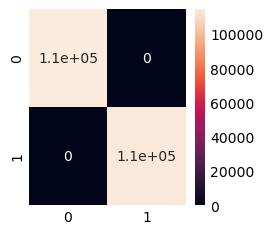

In [47]:

import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions = fitted_models['DT'].predict(X_test)
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True)  

In [ ]:
# from sklearn.metrics import roc_curve
# clf = fitted_models['KNN']
# y = y_test
# pred = clf.predict(X_test)

In [54]:
# roc_auc_score(y_test,pred)

0.9999496202750265

23571/23571 [==============================] - 45s 2ms/step


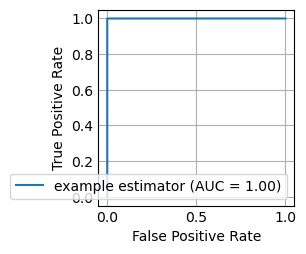

In [51]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import metrics

# fpr, tpr, thresholds = metrics.roc_curve(y, pred)
# roc_auc = metrics.auc(fpr, tpr)
# display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
#                                   estimator_name='example estimator')
# display.plot()

# plt.show()

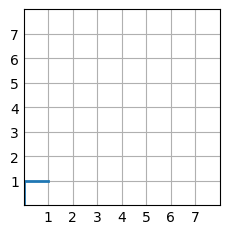

In [36]:
# import matplotlib.pyplot as plt
# plt.style.use('_mpl-gallery')

# # plot
# fig, ax = plt.subplots()

# ax.plot(fpr, tpr, linewidth=2.0)

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))

# plt.show()